# #WaveSight

In [1]:
%load_ext autoreload
%autoreload 2
# assuming there's a file scripto.py in the same folder as the ipynb
import wavesight as ws
import sympy as sp
import numpy as np
from scipy import special
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, root_scalar
import cmasher as cm
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
%config InlineBackend.figure_format='retina'


## ##Jackson Notation

/Users/juan/ZiaLab/Codebase/wavesight/wavesight.py:43: RuntimeWarning: invalid value encountered in sqrt
  return  (n1**2*(special.jv(-1 + n,a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2)) - special.jv(1 + n,a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2))))/(2.*a*n0**2*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2)*special.jv(n,a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2))) + (-special.kn(-1 + n,a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2)) - special.kn(1 + n,a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2)))/(2.*a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2)*special.kn(n,a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2)))


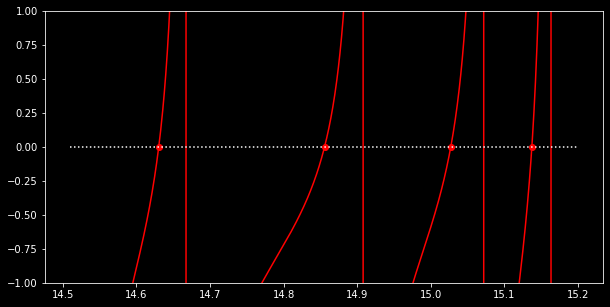

In [756]:
nCore = 1.45
nCladding = 1.387
coreRadius = 3.
wavelength = 0.6
tmfun = ws.tmfungen(λfree=wavelength, 
                 n2=nCladding, 
                 n1=nCore, 
                 a=coreRadius)
kzmax = 1.001*nCore*2*np.pi/wavelength
kzmin = 0.999*nCladding*2*np.pi/wavelength
kzrange = np.linspace(kzmin, kzmax, 1000)
tmvals = tmfun(kzrange)
tmzeros = ws.findallroots(tmfun, kzmin, kzmax, 0.01, method='bisect', num_sigfigs=6, verbose=False)
tmzerocheck = tmfun(tmzeros)
plt.figure(figsize=(10,5))
plt.plot(kzrange, tmvals, 'r')
plt.scatter(tmzeros,tmzerocheck, c='r')
plt.plot([kzmin, kzmax], [0,0], "w:")
plt.ylim(-1,1)
plt.show()

## ##The Fields

In [ ]:
# Solve the propagation constants of a fiber of the given geometry 
# and plot the axial field together with density plots for the tangential
# field

In [148]:
fiber_spec = {'NA': 0.39,
              'nCore': 1.45,
              'coreRadius':50.,
              'free_space_wavelength': 0.600}
fiber_sol = ws.multisolver(fiber_spec, drawPlots=False, verbose=True)

Approx number of complex HE modes:  10322
Approx number of TE modes:  102
Approx number of TE modes:  102
Approx number of total modes:  20849
Calculting TE(0,n) propagation constants...
Calculting TM(0,n) propagation constants...
Calculting HE(n,m) propagation constants...
m=1|

/Users/juan/ZiaLab/Codebase/wavesight/wavesight.py:100: RuntimeWarning: invalid value encountered in sqrt
  return  -((m**2*(1/(-kz**2 + (4*n1**2*np.pi**2)/λfree**2) + 1/(kz**2 - (4*n2**2*np.pi**2)/λfree**2))*(n1**2/(-kz**2 + (4*n1**2*np.pi**2)/λfree**2) + n2**2/(kz**2 - (4*n2**2*np.pi**2)/λfree**2)))/a**2) + ((special.jv(-1 + m,a*np.sqrt(-kz**2 + (4*n1**2*np.pi**2)/λfree**2)) - special.jv(1 + m,a*np.sqrt(-kz**2 + (4*n1**2*np.pi**2)/λfree**2)))/(2.*np.sqrt(-kz**2 + (4*n1**2*np.pi**2)/λfree**2)*special.jv(m,a*np.sqrt(-kz**2 + (4*n1**2*np.pi**2)/λfree**2))) + (-special.kn(-1 + m,a*np.sqrt(kz**2 - (4*n2**2*np.pi**2)/λfree**2)) - special.kn(1 + m,a*np.sqrt(kz**2 - (4*n2**2*np.pi**2)/λfree**2)))/(2.*np.sqrt(kz**2 - (4*n2**2*np.pi**2)/λfree**2)*special.kn(m,a*np.sqrt(kz**2 - (4*n2**2*np.pi**2)/λfree**2))))*((n1**2*(special.jv(-1 + m,a*np.sqrt(-kz**2 + (4*n1**2*np.pi**2)/λfree**2)) - special.jv(1 + m,a*np.sqrt(-kz**2 + (4*n1**2*np.pi**2)/λfree**2))))/(2.*np.sqrt(-kz**2 + (4*n1**2*np.pi**2)/λf

m=2|

/Users/juan/ZiaLab/Codebase/wavesight/wavesight.py:100: RuntimeWarning: invalid value encountered in double_scalars
  return  -((m**2*(1/(-kz**2 + (4*n1**2*np.pi**2)/λfree**2) + 1/(kz**2 - (4*n2**2*np.pi**2)/λfree**2))*(n1**2/(-kz**2 + (4*n1**2*np.pi**2)/λfree**2) + n2**2/(kz**2 - (4*n2**2*np.pi**2)/λfree**2)))/a**2) + ((special.jv(-1 + m,a*np.sqrt(-kz**2 + (4*n1**2*np.pi**2)/λfree**2)) - special.jv(1 + m,a*np.sqrt(-kz**2 + (4*n1**2*np.pi**2)/λfree**2)))/(2.*np.sqrt(-kz**2 + (4*n1**2*np.pi**2)/λfree**2)*special.jv(m,a*np.sqrt(-kz**2 + (4*n1**2*np.pi**2)/λfree**2))) + (-special.kn(-1 + m,a*np.sqrt(kz**2 - (4*n2**2*np.pi**2)/λfree**2)) - special.kn(1 + m,a*np.sqrt(kz**2 - (4*n2**2*np.pi**2)/λfree**2)))/(2.*np.sqrt(kz**2 - (4*n2**2*np.pi**2)/λfree**2)*special.kn(m,a*np.sqrt(kz**2 - (4*n2**2*np.pi**2)/λfree**2))))*((n1**2*(special.jv(-1 + m,a*np.sqrt(-kz**2 + (4*n1**2*np.pi**2)/λfree**2)) - special.jv(1 + m,a*np.sqrt(-kz**2 + (4*n1**2*np.pi**2)/λfree**2))))/(2.*np.sqrt(-kz**2 + (4*n1**2*np

m=3|m=4|m=5|m=6|m=7|m=8|m=9|m=10|m=11|m=12|m=13|m=14|m=15|m=16|m=17|m=18|m=19|m=20|m=21|m=22|m=23|m=24|m=25|m=26|m=27|m=28|m=29|m=30|m=31|m=32|m=33|m=34|m=35|m=36|m=37|m=38|m=39|m=40|m=41|m=42|m=43|m=44|m=45|m=46|m=47|m=48|m=49|m=50|m=51|m=52|m=53|m=54|m=55|m=56|m=57|m=58|m=59|m=60|m=61|m=62|m=63|m=64|m=65|m=66|m=67|m=68|m=69|m=70|m=71|m=72|m=73|m=74|m=75|m=76|m=77|m=78|m=79|m=80|m=81|m=82|m=83|m=84|m=85|m=86|m=87|m=88|m=89|m=90|m=91|m=92|m=93|m=94|m=95|m=96|m=97|m=98|m=99|m=100|m=101|m=102|m=103|m=104|m=105|m=106|m=107|m=108|

In [98]:
Vnum = fiber_sol['Vnum']
len(fiber_sol['TEkz']),len(fiber_sol['TMkz']), sum(list(map(len,fiber_sol['HEkz'].values())))

(4, 4, 15)

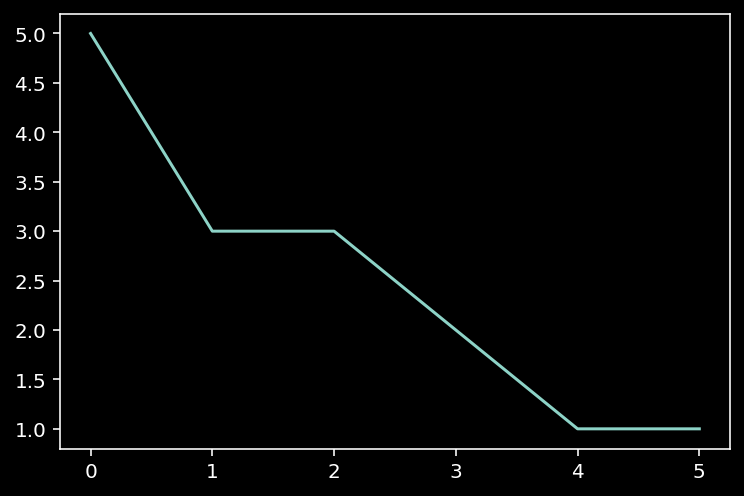

In [99]:
TEcounter = list(map(len,fiber_sol['HEkz'].values()))
plt.figure()
plt.plot(TEcounter)
plt.show()

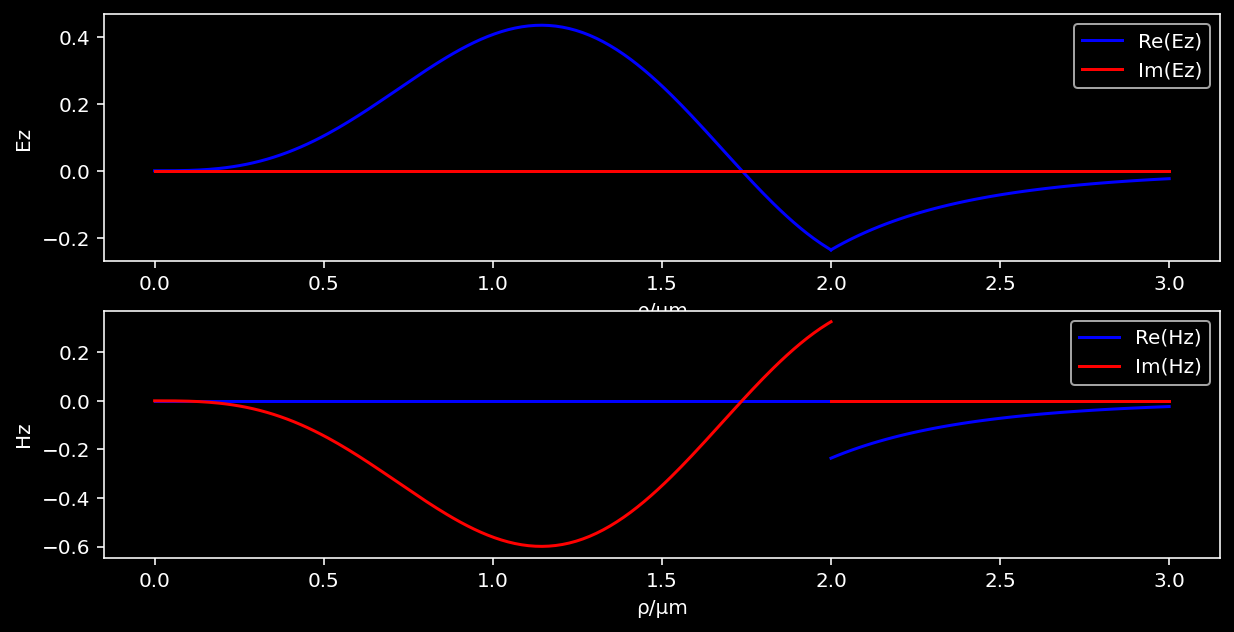

In [134]:
a = fiber_sol['coreRadius']
b = a*1.5 # assumed, in reality the cladding is assumed to be infinite
nCore = fiber_sol['nCore']
nCladding = fiber_sol['nCladding']

# given a value for m, plot the axial and transverse fields
m = 3
kz = fiber_sol['HEkz'][m][0]
λfree = fiber_sol['free_space_wavelength']
γ = np.sqrt(nCore**2*4*np.pi**2/λfree**2 - kz**2)
β = np.sqrt(kz**2 - nCladding**2*4*np.pi**2/λfree**2)

Ae, Ah, Be, Bh = ws.AeAhBeBh(a, nCore, nCladding, λfree, m, kz)

Ez_1 = ws.Ezgen_1(Ae, m, γ)
Ez_2 = ws.Ezgen_2(Be, m, β)
Hz_1 = ws.Hzgen_1(Ah, m, γ)
Hz_2 = ws.Hzgen_2(Be, m, β)

Et1 = ws.Et1gen_1(Ae, Ah, Be, Bh, m, β, γ, kz, λfree)
Et2 = ws.Et2gen_1(Ae, Ah, Be, Bh, m, β, γ, kz, λfree)
Ht1 = ws.Ht1gen_1(Ae, Ah, Be, Bh, m, β, γ, kz, λfree, nCore)
Ht2 = ws.Ht2gen_1(Ae, Ah, Be, Bh, m, β, γ, kz, λfree, nCladding)

ρrangein = np.linspace(0, a, 200)
ρrangeout = np.linspace(a, b, 50)

Ezvals1 = Ez_1(ρrangein)
Ezvals2 = Ez_2(ρrangeout)
Hzvals1 = Hz_1(ρrangein)
Hzvals2 = Hz_2(ρrangeout)

fig, ax = plt.subplots(nrows=2,figsize=(10,5))
ax[0].plot(ρrangein, np.real(Ezvals1), 'b', label='Re(Ez)')
ax[0].plot(ρrangeout, np.real(Ezvals2), 'b')
ax[0].plot(ρrangein, np.imag(Ezvals1), 'r', label='Im(Ez)')
ax[0].plot(ρrangeout, np.imag(Ezvals2), 'r')
ax[0].set_xlabel('ρ/µm')
ax[0].set_ylabel('Ez')
ax[0].legend()
ax[1].plot(ρrangein, np.real(Hzvals1),'b', label='Re(Hz)')
ax[1].plot(ρrangeout, np.real(Hzvals2),'b')
ax[1].plot(ρrangein, np.imag(Hzvals1),'r', label='Im(Hz)')
ax[1].plot(ρrangeout, np.imag(Hzvals2),'r')
ax[1].set_xlabel('ρ/µm')
ax[1].set_ylabel('Hz')
ax[1].legend()
plt.subplots_adjust()
plt.show()

In [135]:
xrange = np.linspace(-b, b, 200)
yrange = np.linspace(-b, b, 200)
X, Y = np.meshgrid(xrange, yrange)
Etvals1 = Et1(X, Y)
Etvals2 = Et2(X, Y)
Htvals1 = Ht1(X, Y)
Htvals2 = Ht2(X, Y)

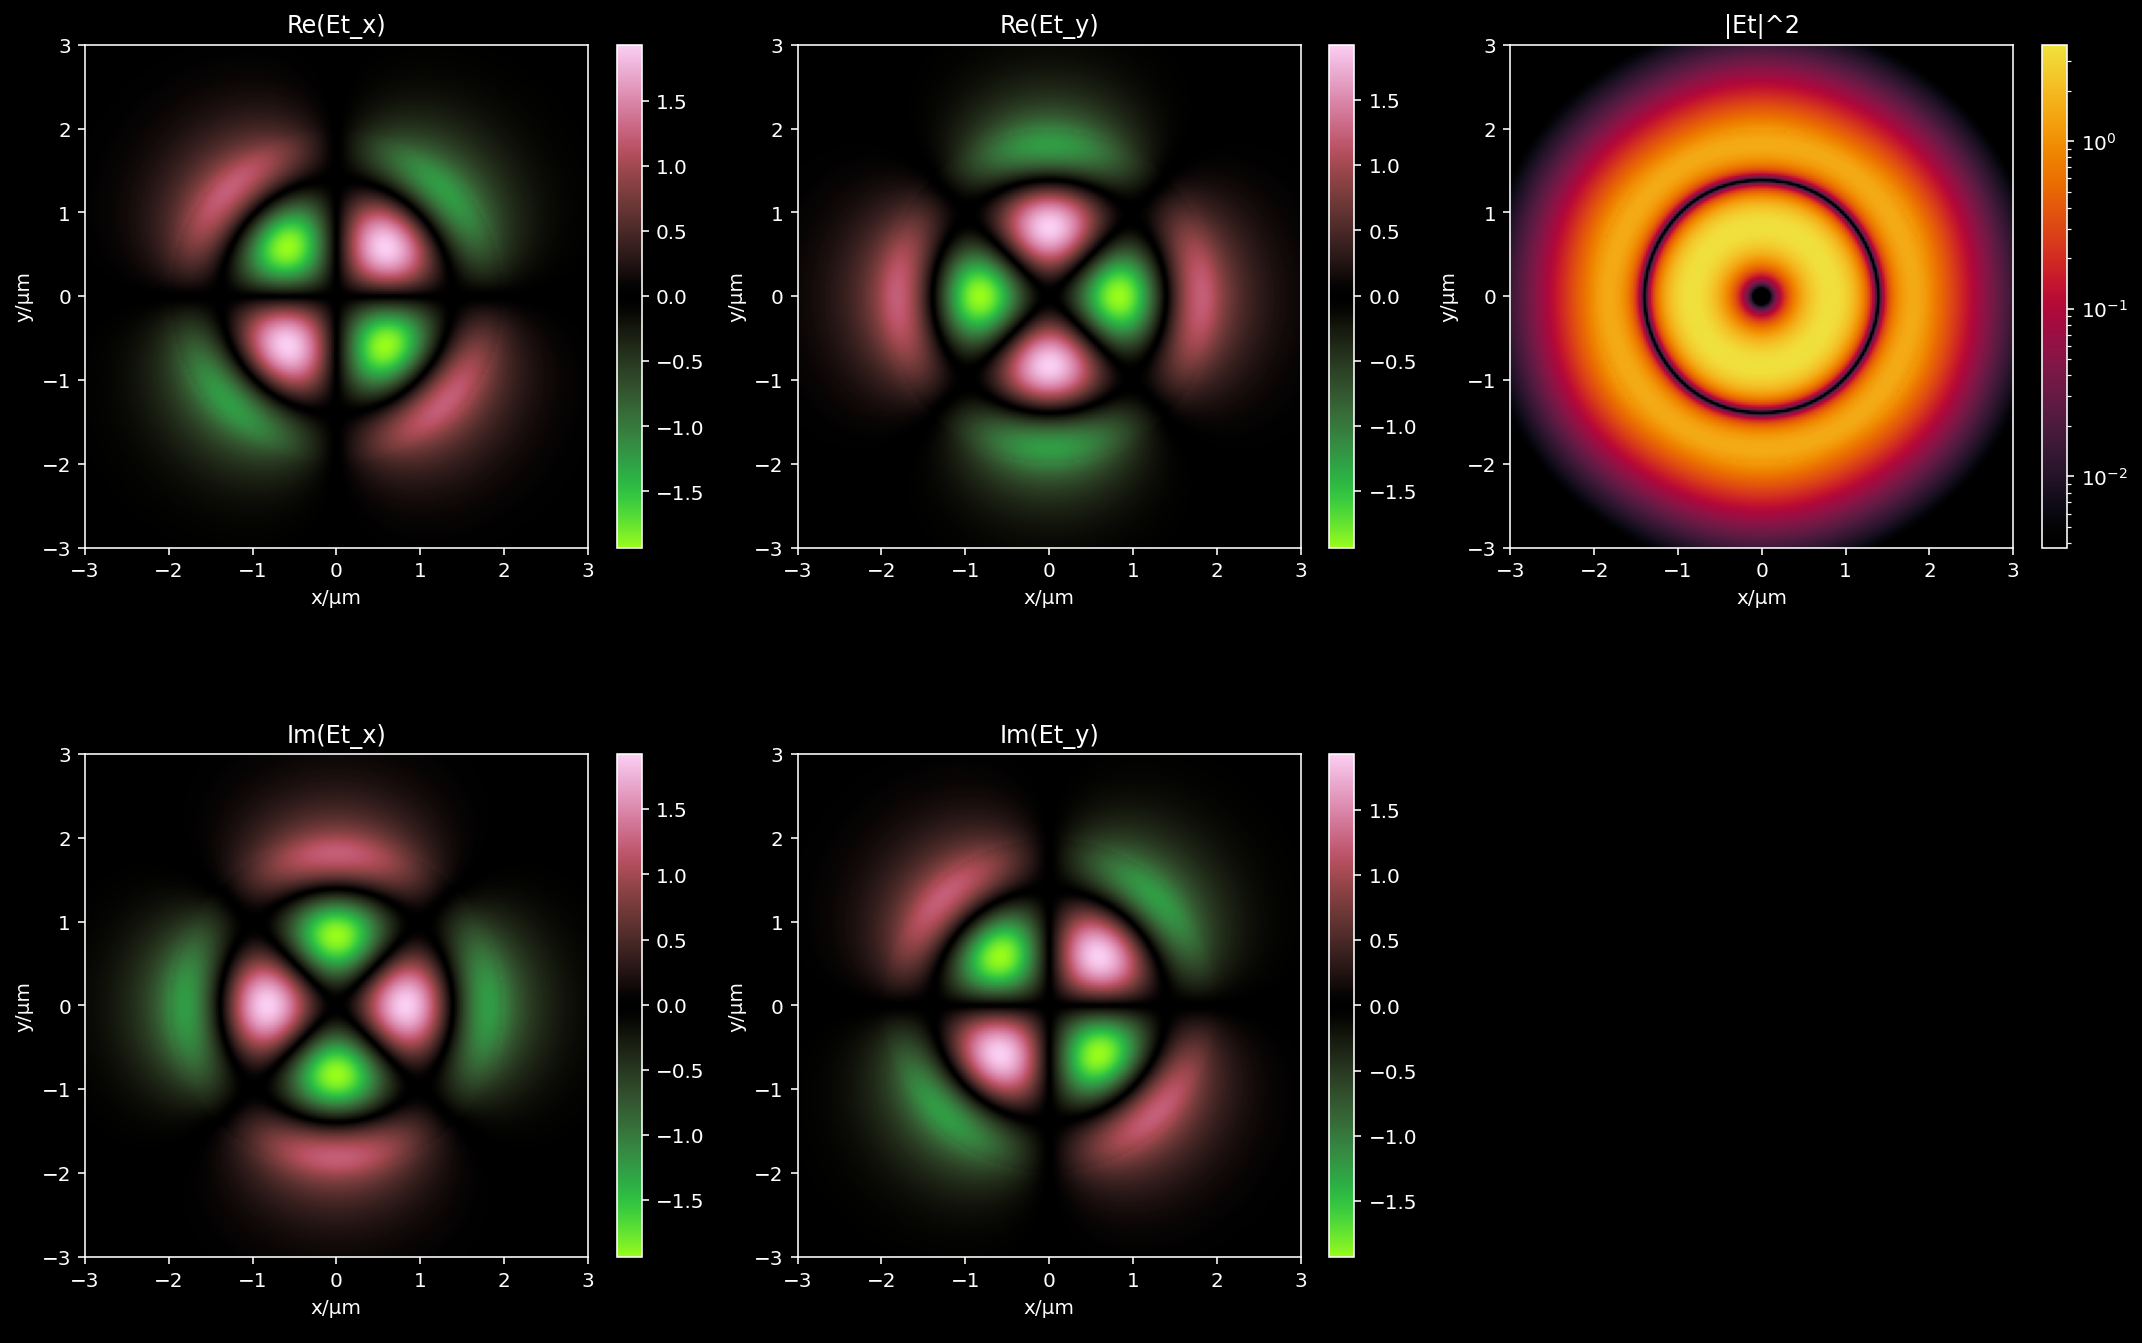

In [139]:
fieldarray1 = np.real(Etvals1[0,:,])
fieldarray1[X**2 + Y**2 > a**2] = 0
fieldarray2 = np.real(Etvals2[0,:,])
fieldarray2[X**2 + Y**2 < a**2] = 0
fieldarray_x = fieldarray1 + fieldarray2

fieldarray1 = np.real(Etvals1[1,:,])
fieldarray1[X**2 + Y**2 > a**2] = 0
fieldarray2 = np.real(Etvals2[1,:,])
fieldarray2[X**2 + Y**2 < a**2] = 0
fieldarray_y = fieldarray1 + fieldarray2

fieldarray1 = np.real(Etvals1[0,:,])**2 + np.real(Etvals1[1,:,])**2
fieldarray1[X**2 + Y**2 > a**2] = 0
fieldarray2 = np.real(Etvals2[0,:,])**2 + np.real(Etvals2[1,:,])**2
fieldarray2[X**2 + Y**2 < a**2] = 0
fieldarray_mag2 = fieldarray1 + fieldarray2

fieldarray1 = np.imag(Etvals1[0,:,])
fieldarray1[X**2 + Y**2 > a**2] = 0
fieldarray2 = np.imag(Etvals2[0,:,])
fieldarray2[X**2 + Y**2 < a**2] = 0
fieldarray_xim = fieldarray1 + fieldarray2

fieldarray1 = np.imag(Etvals1[1,:,])
fieldarray1[X**2 + Y**2 > a**2] = 0
fieldarray2 = np.imag(Etvals2[1,:,])
fieldarray2[X**2 + Y**2 < a**2] = 0
fieldarray_yim = fieldarray1 + fieldarray2

plotfields = [fieldarray_x, fieldarray_y, fieldarray_mag2, fieldarray_xim, fieldarray_yim]

labels = ['Re(Et_x)', 'Re(Et_y)', '|Et|^2', 'Im(Et_x)', 'Im(Et_y)']

fig, axes = plt.subplots(nrows = 2, ncols=3, figsize=(15,10))

for idx, (pfield, label) in enumerate(zip(plotfields, labels)):
    ax = axes[idx//3, idx%3]
    if label == '|Et|^2':
        cmap = cm.ember
        maxmag2 = np.max(fieldarray_mag2)
        iplot = ax.imshow(fieldarray_mag2, 
                norm=LogNorm(vmin=maxmag2*1e-3, vmax=maxmag2),
                cmap=cmap, 
                extent=[-a*1.5, a*1.5, -a*1.5, a*1.5])
    else:
        cmap = cm.watermelon
        iplot = ax.imshow(pfield, 
            cmap=cmap, 
            extent=[-a*1.5, a*1.5, -a*1.5, a*1.5])
    ax.set_title(label)
    ax.set_xlabel('x/µm')
    ax.set_ylabel('y/µm')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    plt.colorbar(iplot, cax=cax)

axes[1,2].set_axis_off()

plt.tight_layout()
plt.show()

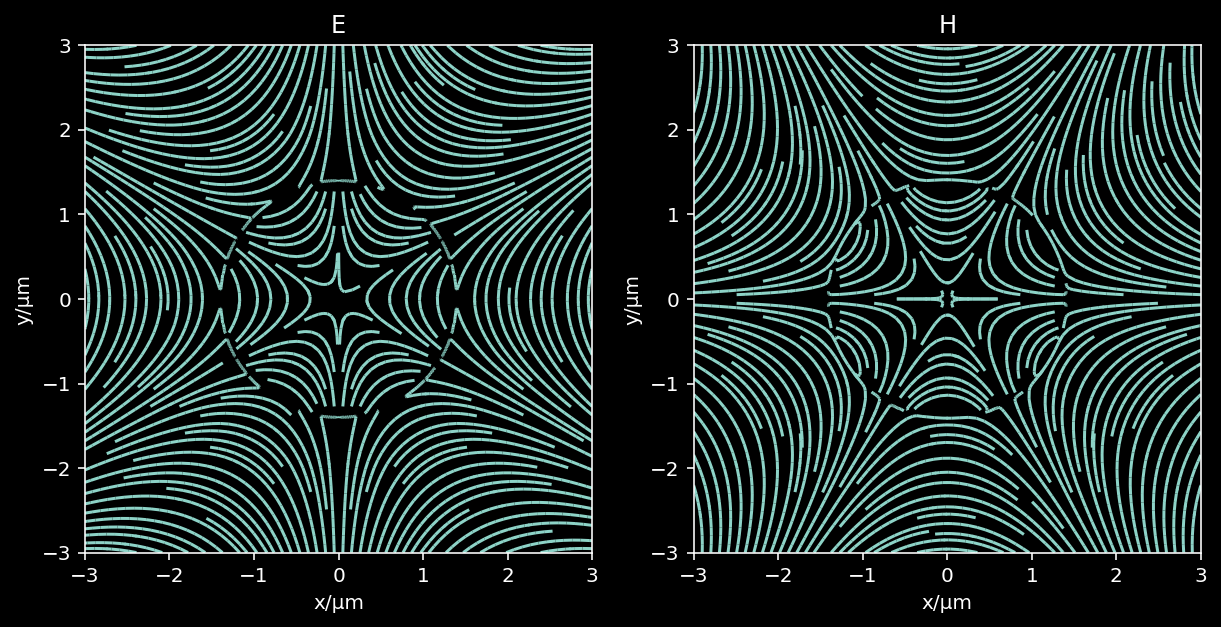

In [147]:
Ex1 = np.real(Etvals1[0,:,:])
Ex1[X**2 + Y**2 > a**2] = 0
Ex2 = np.real(Etvals2[0,:,:])
Ex2[X**2 + Y**2 < a**2] = 0
Ex = Ex1 + Ex2
Ey1 = np.real(Etvals1[1,:,:])
Ey1[X**2 + Y**2 > a**2] = 0
Ey2 = np.real(Etvals2[1,:,:])
Ey2[X**2 + Y**2 < a**2] = 0
Ey = Ey1 + Ey2

Hx1 = np.real(Htvals1[0,:,:])
Hx1[X**2 + Y**2 > a**2] = 0
Hx2 = np.real(Htvals2[0,:,:])
Hx2[X**2 + Y**2 < a**2] = 0
Hx = Hx1 + Hx2
Hy1 = np.real(Htvals1[1,:,:])
Hy1[X**2 + Y**2 > a**2] = 0
Hy2 = np.real(Htvals2[1,:,:])
Hy2[X**2 + Y**2 < a**2] = 0
Hy = Hy1 + Hy2

fig, axes = plt.subplots(ncols=2, figsize=(10,5))
axes[0].streamplot(xrange, yrange, Ex, Ey, arrowstyle='-', density=2)
axes[0].set_xlabel('x/µm')
axes[0].set_ylabel('y/µm')
axes[0].set_title('E')
axes[0].set_aspect('equal')

axes[1].streamplot(xrange, yrange, Hx, Hy, arrowstyle='-', density=2)
axes[1].set_xlabel('x/µm')
axes[1].set_ylabel('y/µm')
axes[1].set_title('H')
axes[1].set_aspect('equal')
plt.show()

## ##Gray Notation (deprecated)

/Users/juan/ZiaLab/Codebase/wavesight/wavesight.py:19: RuntimeWarning: invalid value encountered in sqrt
  return  (n1**2*(special.jv(-1 + n,a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2)) - special.jv(1 + n,a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2))))/(2.*a*n0**2*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2)*special.jv(n,a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2))) + (-special.kn(-1 + n,a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2)) - special.kn(1 + n,a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2)))/(2.*a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2)*special.kn(n,a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2)))


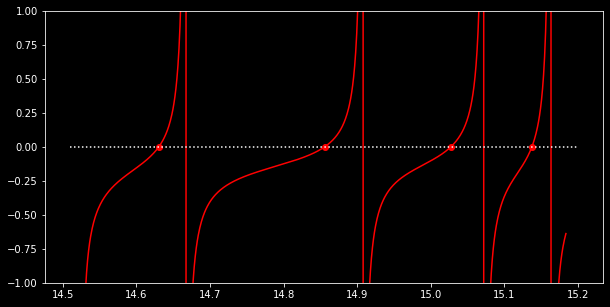

In [ ]:
nCore = 1.45
nCladding = 1.387
coreRadius = 3.
wavelength = 0.6
tmfun = ws.tmfungen(λfree=wavelength, 
                 n=0, 
                 n0=nCladding, 
                 n1=nCore, 
                 a=coreRadius)
γmax = 1.001*nCore*2*np.pi/wavelength
γmin = 0.999*nCladding*2*np.pi/wavelength
γrange = np.linspace(γmin, γmax, 1000)
tmvals = tmfun(γrange)
tmzeros = ws.findallroots(tmfun, γmin, γmax, 0.01, method='bisect', num_decimals=6, verbose=False)
tmzerocheck = tmfun(tmzeros)
plt.figure(figsize=(10,5))
plt.plot(γrange, tmvals, 'r')
plt.scatter(tmzeros,tmzerocheck, c='r')
plt.plot([γmin, γmax], [0,0], "w:")
plt.ylim(-1,1)
plt.show()

/Users/juan/ZiaLab/Codebase/wavesight/wavesight.py:25: RuntimeWarning: invalid value encountered in sqrt
  return (special.jv(-1 + n,a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2)) - special.jv(1 + n,a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2)))/(2.*a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2)*special.jv(n,a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2))) + (-special.kn(-1 + n,a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2)) - special.kn(1 + n,a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2)))/(2.*a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2)*special.kn(n,a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2)))


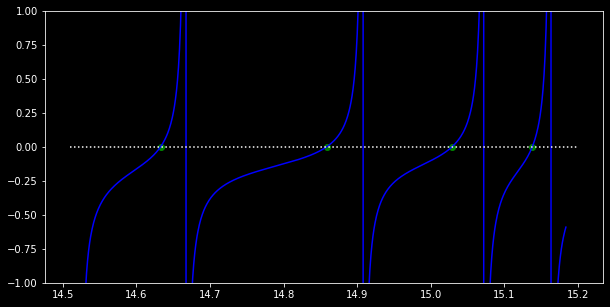

In [ ]:
nCore = 1.45
nCladding = 1.387
coreRadius = 3.
wavelength = 0.6
tefun = ws.tefungen(λfree=wavelength, 
                 n=0, 
                 n0=nCladding, 
                 n1=nCore, 
                 a=coreRadius)
γmax = 1.001*nCore*2*np.pi/wavelength
γmin = 0.999*nCladding*2*np.pi/wavelength
γrange = np.linspace(γmin, γmax, 1000)
tevals = tefun(γrange)
tezeros = ws.findallroots(tefun, γmin, γmax, 0.01, method='bisect', num_decimals=6)
tezerocheck = tefun(tezeros)
plt.figure(figsize=(10,5))
plt.plot(γrange, tevals, 'b')
plt.scatter(tezeros,tezerocheck, c='g')
plt.plot([γmin, γmax], [0,0], "w:")
plt.ylim(-1,1)
plt.show()

/Users/juan/ZiaLab/Codebase/wavesight/wavesight.py:30: RuntimeWarning: invalid value encountered in sqrt
  return  -((n**2*(1/(γ**2 - (4*n0**2*np.pi**2)/λfree**2) + 1/(-γ**2 + (4*n1**2*np.pi**2)/λfree**2))*(1/(a**2*(γ**2 - (4*n0**2*np.pi**2)/λfree**2)) + n1**2/(a**2*n0**2*(-γ**2 + (4*n1**2*np.pi**2)/λfree**2))))/a**2) + ((special.jv(-1 + n,a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2)) - special.jv(1 + n,a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2)))/(2.*a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2)*special.jv(n,a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2))) + (-special.kn(-1 + n,a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2)) - special.kn(1 + n,a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2)))/(2.*a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2)*special.kn(n,a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2))))*((n1**2*(special.jv(-1 + n,a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2)) - special.jv(1 + n,a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2))))/(2.*a*n0**2*np.sqrt(-γ**2 + (4*n1**2*

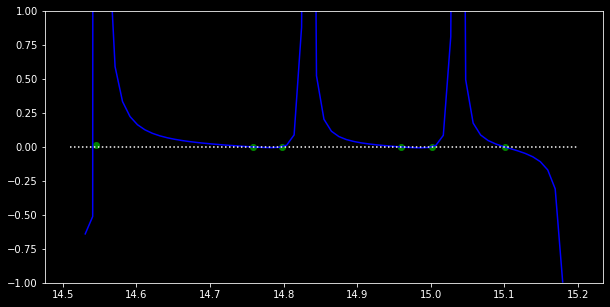

In [ ]:
nCore = 1.45
nCladding = 1.387
coreRadius = 3.
wavelength = 0.6
n=3
hefun = ws.hefungen(λfree=wavelength, 
                 n=n, 
                 n0=nCladding, 
                 n1=nCore, 
                 a=coreRadius)
γmax = 1.001*nCore*2*np.pi/wavelength
γmin = 0.999*nCladding*2*np.pi/wavelength
# γrange = np.linspace(γmin, γmax, 1000)
dx = 0.01
γrange = np.linspace(γmin, γmax, int(np.ceil((γmax-γmin)/dx)))
hevals = hefun(γrange)
zc = ws.zerocrossings(hevals)
zcvals = hevals[zc]
good_crossings = np.where(~np.isnan(zcvals))
zcvals = zcvals[good_crossings]
zc = zc[good_crossings]
hezeros = ws.findallroots(hefun, γmin, γmax, dx, method='bisect', num_decimals=6, verbose=False)
hezerocheck = hefun(hezeros)
plt.figure(figsize=(10,5))
plt.plot(γrange, hevals, 'b')
plt.scatter(hezeros,hezerocheck, c='g')
plt.plot([γmin, γmax], [0,0], "w:")
plt.ylim(-1,1)
plt.show()